# Genome Shots

Browser shots.

**Inputs**: 
1. Config:
    - For each cluster, colour, description, new cluster number (set to same as original if it should not be changed)
2. Bigwig files per cluster

In [1]:
library(ggplot2)
library(Gviz)
library(GenomicRanges)
library(patchwork)
library(ggplotify)
library(rtracklayer)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min



Attaching package: ‘S4Vectors’


The

In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")

## Loading Inputs

### Day and Cluster Configs

In [3]:
day_config = read.table("../configs/day.tsv", comment.char = '', header=T)
day_config$colour = as.character(day_config$colour)
day_config$day = factor(day_config$day, levels=DAYS)
rownames(day_config) = day_config$day
day_config

,day,colour
,<fct>,<chr>
D0,D0,#336699
D2,D2,#0AABB7
D4,D4,#D6E82F
D6,D6,#B14AED
D8,D8,#2D3142
D10,D10,#FC7753
D12,D12,#FF70A6
D14,D14,#A61C24


In [31]:
cluster_config = read.table("../configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

rownames(cluster_config) = cluster_config$cluster
cluster_config

,cluster,colour,description,new_cluster
,<int>,<chr>,<chr>,<int>
1,1,#CCCCCC,Intermediate,12
2,2,#E41A1C,Pre-iPSC,15
3,3,#377EB8,Fibroblast-like,5
4,4,#4DAF4A,Fibroblast-like,3
5,5,#984EA3,Fibroblast,1
6,6,#FF7F00,Fibroblast,2
7,7,#4B644A,Fibroblast-like,4
8,8,#A65628,Doublets,17
9,9,#F781BF,Keratinocyte-like,6


### BigWig List

In [5]:
cluster_bigwigs = read.table("../configs/cluster_bigwigs.tsv", header=T)
cluster_bigwigs$path = as.character(cluster_bigwigs$path)
rownames(cluster_bigwigs) = cluster_bigwigs$cluster
head(cluster_bigwigs)

,cluster,path
,<int>,<chr>
1,1,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20200518_n76052/croo/cluster_idx1/signal/rep1/cluster_idx1.pval.signal.bigwig
2,2,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20200518_n76052/croo/cluster_idx2/signal/rep1/cluster_idx2.pval.signal.bigwig
3,3,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20200518_n76052/croo/cluster_idx3/signal/rep1/cluster_idx3.pval.signal.bigwig
4,4,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20200518_n76052/croo/cluster_idx4/signal/rep1/cluster_idx4.pval.signal.bigwig
5,5,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20200518_n76052/croo/cluster_idx5/signal/rep1/cluster_idx5.pval.signal.bigwig
6,6,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20200518_n76052/croo/cluster_idx6/signal/rep1/cluster_idx6.pval.signal.bigwig


### Gene Model

In [6]:
gencode.basic.hg38 = import.gff(gzfile("../../../resources/GENCODE/gencode.v33.chr_patch_hapl_scaff.basic.annotation.gtf.gz"))
gencode.basic.hg38 = keepStandardChromosomes(gencode.basic.hg38, pruning.mode = "coarse")
gene_anno <- data.frame(gencode.basic.hg38)
gene_anno = gene_anno[!is.na(gene_anno$exon_number), ]
gene_anno = gene_anno[gene_anno$gene_type=="protein_coding", ]

# rename some columns to match requirements
gene_anno$chromosome <-  gene_anno$seqnames
gene_anno$gene <- gene_anno$gene_id
gene_anno$transcript <- gene_anno$transcript_name
gene_anno$symbol <- gene_anno$gene_name

gene_anno$feature = as.character(gene_anno$type)
gene_anno$exon = gene_anno$exon_id
gene_anno = gene_anno[,c("chromosome", "start", "end", "strand", "gene", "symbol", "transcript", "feature", "exon")]
head(gene_anno)

Warning message in readGFF(filepath, version = version, filter = filter):
"connection is not positioned at the start of the file, rewinding it"


,chromosome,start,end,strand,gene,symbol,transcript,feature,exon
,<fct>,<int>,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>
57,chr1,65419,65433,+,ENSG00000186092.6,OR4F5,OR4F5-202,exon,ENSE00003812156.1
58,chr1,65520,65573,+,ENSG00000186092.6,OR4F5,OR4F5-202,exon,ENSE00003813641.1
59,chr1,65565,65573,+,ENSG00000186092.6,OR4F5,OR4F5-202,CDS,ENSE00003813641.1
60,chr1,65565,65567,+,ENSG00000186092.6,OR4F5,OR4F5-202,start_codon,ENSE00003813641.1
61,chr1,69037,71585,+,ENSG00000186092.6,OR4F5,OR4F5-202,exon,ENSE00003813949.1
62,chr1,69037,70005,+,ENSG00000186092.6,OR4F5,OR4F5-202,CDS,ENSE00003813949.1


## Plotting

In [7]:
get_region_tracks <- function(chr, gene_anno, cluster_config, cluster_bigwigs, show_axis=T) {
    bw_tracks = c()
    for (i in seq(nrow(cluster_config))) {
        cur_bw_path = cluster_bigwigs[i, "path"]
        cur_bw_track = DataTrack(cur_bw_path, 
                             genome="hg38", 
                             chromosome = chr, 
                             name=sprintf("%s", cluster_config[i, "new_cluster"]),
                             ylim=c(0,42),
                             type="histogram",
                             col.histogram=cluster_config[i, "colour"],
                             background.title = cluster_config[i, "colour"], littleTicks=F)
        
        # don't show axis ticks for each plot
        displayPars(cur_bw_track)$showAxis = F
        if (!show_axis) {
            displayPars(cur_bw_track)$showTitle = F
        }
        
        bw_tracks = c(bw_tracks, cur_bw_track)
    }
    
    bw_tracks = bw_tracks[order(cluster_config$new_cluster)] # reorder
    
    gene_track = GeneRegionTrack(gene_anno, genome = "hg38", 
                                 chromosome = chr, 
                                 name = "", 
                                 collapseTranscripts="longest",
                                 transcriptAnnotation="symbol",
                                background.title = 'transparent',
                                fill='#000000',
                                stackHeight=0.5)
    
    if (!show_axis) {
            displayPars(gene_track)$showTitle = F
            displayPars(gene_track)$showAxis = F
        }
    
    bw_tracks = c(bw_tracks, gene_track)
    
    bw_tracks
}

### Prototype

In [8]:
bw_tracks = get_region_tracks("chr16", gene_anno, cluster_config[1:2,], cluster_bigwigs, show_axis=T)

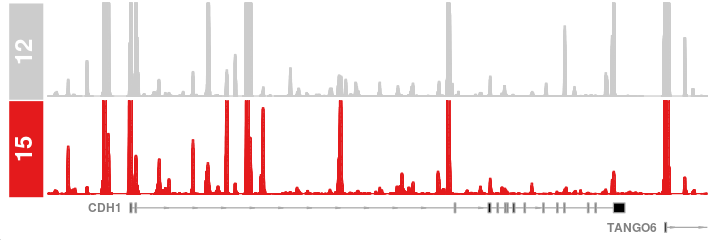

In [9]:
options(repr.plot.width = 6, repr.plot.height = 2)
as.ggplot(~plotTracks(bw_tracks, from=68720914, to=68851918))

In [10]:
gene_track = GeneRegionTrack(gene_anno, genome = "hg38", 
                                 chromosome = "chr16", 
                                 name = "", 
                                 collapseTranscripts="longest",
                                 transcriptAnnotation="symbol",
                                background.title = 'transparent')

gene_track2 = GeneRegionTrack(gene_anno, genome = "hg38", 
                                 chromosome = "chr16", 
                                 name = "", 
                                 collapseTranscripts="longest",
                                 transcriptAnnotation="symbol",
                                background.title = 'transparent',
                             stackHeight=0.5, fill='#000000', min.height=20)

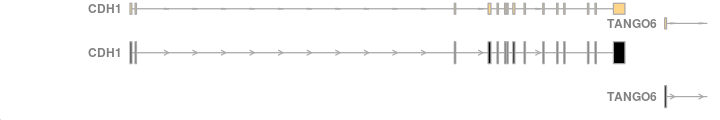

In [11]:
options(repr.plot.width = 6, repr.plot.height = 1)

as.ggplot(~plotTracks(c(gene_track, gene_track2), from=68720914, to=68851918, sizes=c(1,3)))

### Panels

In [76]:
bw_tracks = get_region_tracks("chr16", gene_anno, cluster_config, cluster_bigwigs, show_axis=T)
CDH1 = as.ggplot(~plotTracks(bw_tracks, from=68720914, to=68851918, 
                             sizes=rep(1,nrow(cluster_config)+1))) +
       ggtitle("CDH1") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
             panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [85]:
bw_tracks = get_region_tracks("chr12", gene_anno, cluster_config, cluster_bigwigs, show_axis=F)
NANOG = as.ggplot(~plotTracks(bw_tracks, from=7781273, to=7807263,
                             sizes=rep(1,nrow(cluster_config)+1)))+
       ggtitle("NANOG") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [79]:
bw_tracks = get_region_tracks("chr6", gene_anno, cluster_config, cluster_bigwigs, show_axis=F)
POU5F1 = as.ggplot(~plotTracks(bw_tracks, from=31156139, to=31188929,
                              sizes=rep(1,nrow(cluster_config)+1)))+
       ggtitle("OCT4") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [80]:
bw_tracks = get_region_tracks("chr17", gene_anno, cluster_config, cluster_bigwigs, show_axis=F)
COL1A1 = as.ggplot(~plotTracks(bw_tracks, from=50178384, to=50208975,
                              sizes=rep(1,nrow(cluster_config)+1)))+
       ggtitle("COL1A1") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [81]:
cluster_label_df = cluster_config

BOTTOM_PT = nrow(cluster_label_df)+0.7

cluster_label_df[nrow(cluster_label_df)+1, ] = c(nrow(cluster_label_df)+1, "", "", 1)
cluster_label_df[nrow(cluster_label_df)+1, ] = c(nrow(cluster_label_df)+1, "", "", BOTTOM_PT)

# need to play around with these parameters to find the right fit
cluster_labels_plot <- ggplot(cluster_label_df) +
    geom_text(aes(x=0, y= -as.numeric(new_cluster), label=description, hjust=1, vjust=0.5)) +
    theme_void() +
    theme(plot.margin = unit(c(0,-105,0,0), "pt"))

# add to debug- shows how ggplot dots align with genome track labels
# for (i in seq(1,18)) {
#     cluster_labels_plot = cluster_labels_plot + geom_point(x=0, y= -i)
# }

# cluster_labels_plot = cluster_labels_plot + geom_point(x=0, y= -BOTTOM_PT, colour='red')

In [86]:
myplot = wrap_plots(cluster_labels_plot,
                    CDH1,
                    plot_spacer(),
                    NANOG,
                    plot_spacer(),
                    POU5F1,
                    plot_spacer(),
                    COL1A1, widths=c(3,6,0,6,0,6,0,6))

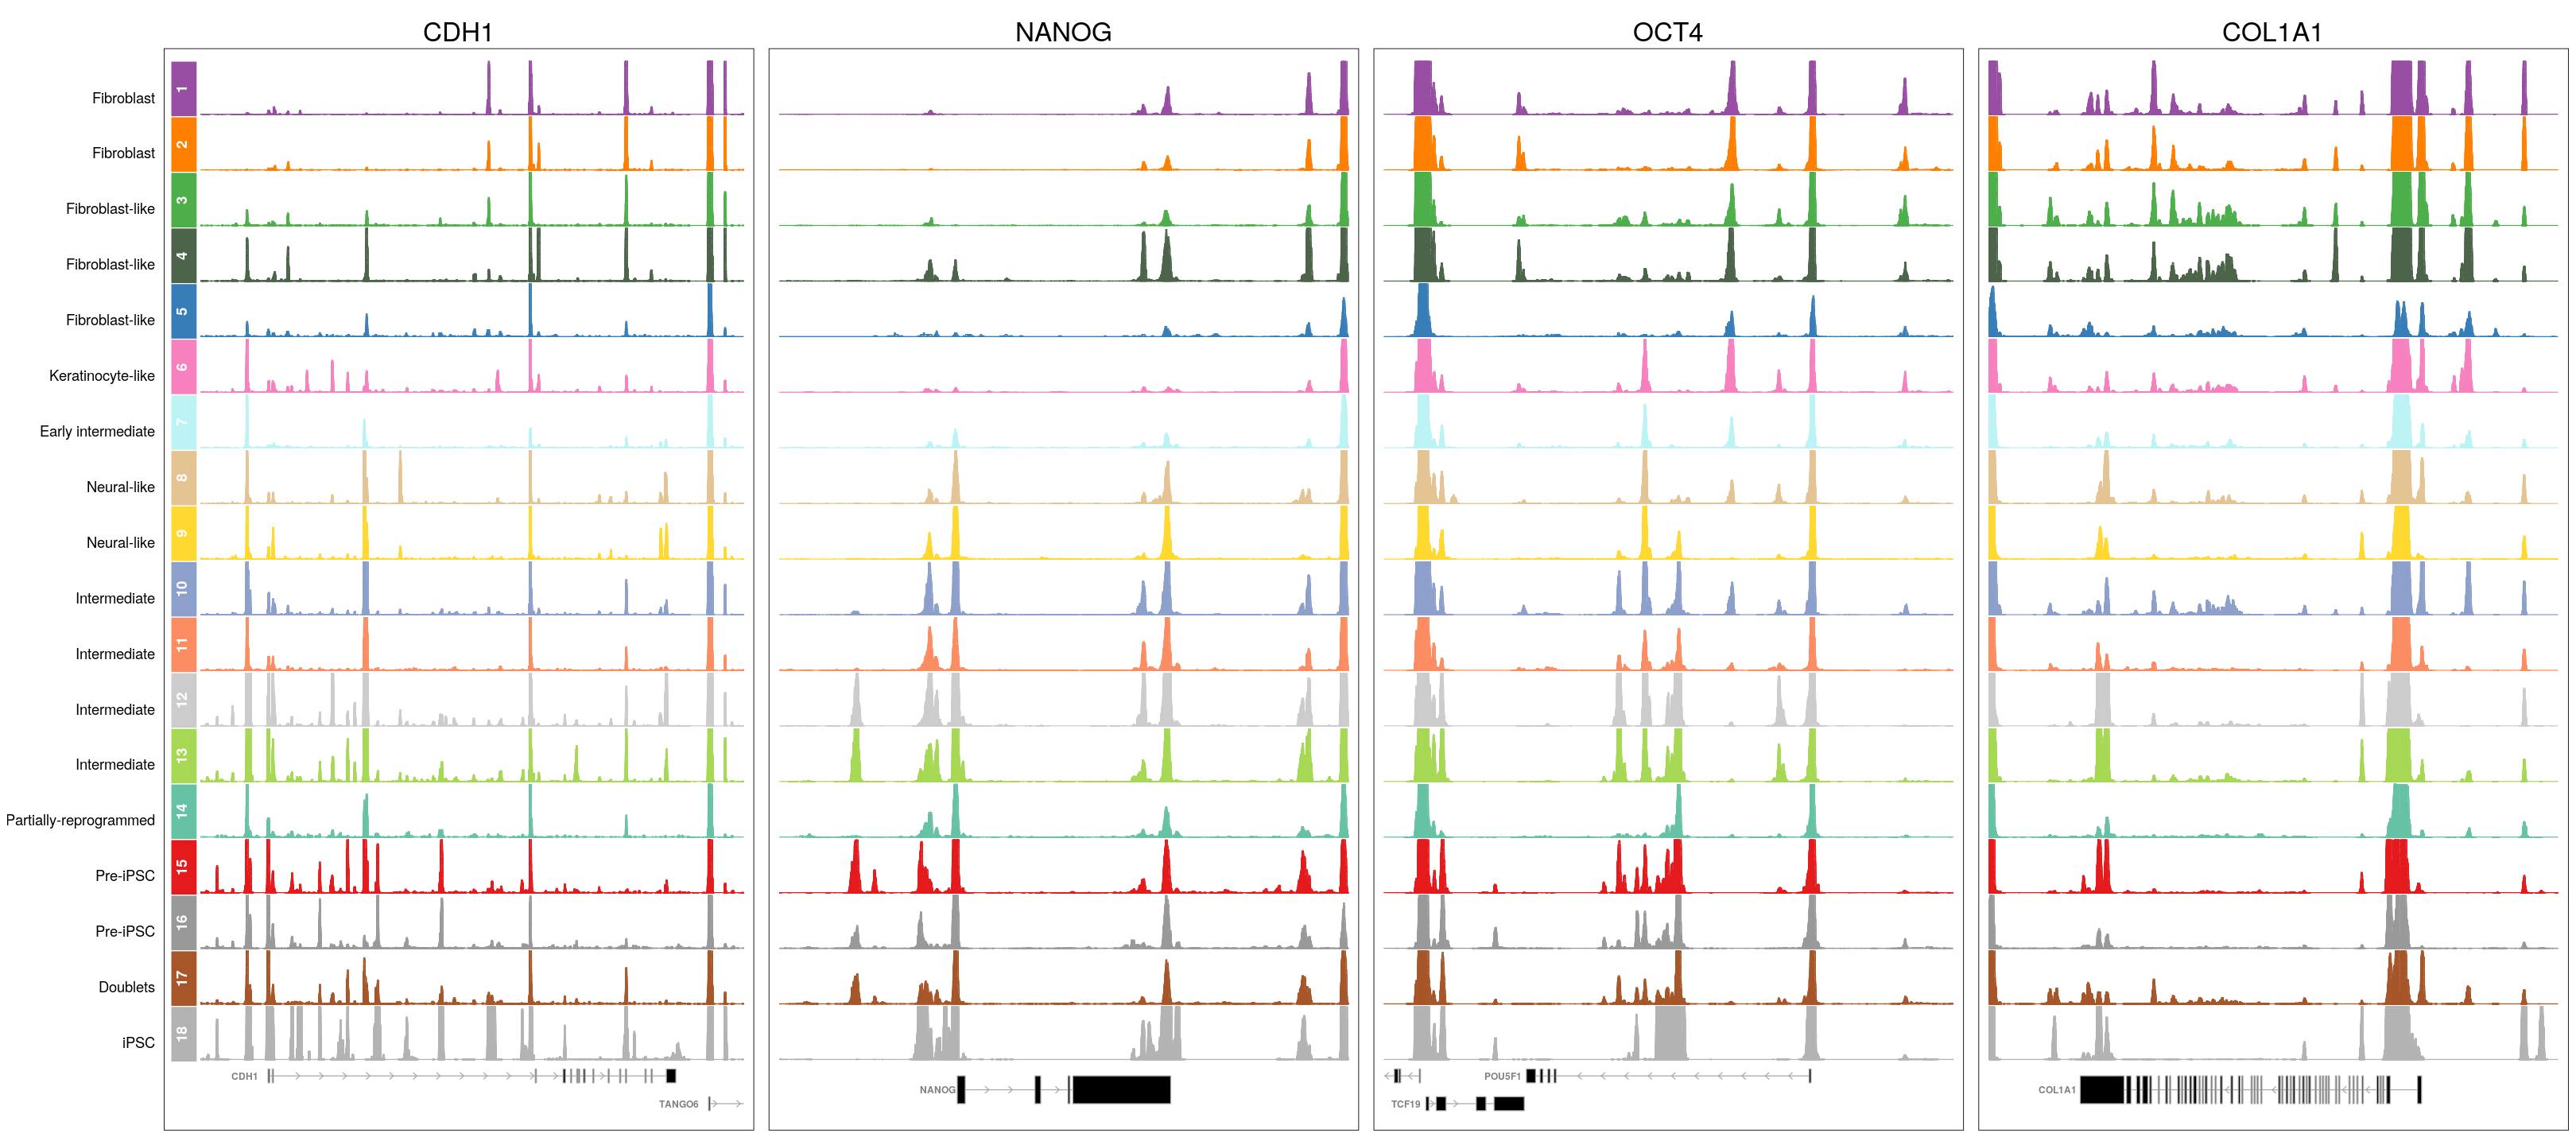

In [87]:
options(repr.plot.width = 27, repr.plot.height = 12)

myplot

In [88]:
ggsave("tmp.png", myplot, height=12, width=27)

## For D2 heterogeneity Fig 2, copy over later

In [89]:
bw_tracks = get_region_tracks("chr2", gene_anno, cluster_config, cluster_bigwigs, show_axis=T)
MAP2 = as.ggplot(~plotTracks(bw_tracks, from=209402919, to=209743439,
                              sizes=rep(1,nrow(cluster_config)+1)))+
       ggtitle("MAP2") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [92]:
bw_tracks = get_region_tracks("chr4", gene_anno, cluster_config, cluster_bigwigs, show_axis=F)
GPM6A = as.ggplot(~plotTracks(bw_tracks, from=175604036, to=176018217,
                              sizes=rep(1,nrow(cluster_config)+1)))+
       ggtitle("GPM6A") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [93]:
bw_tracks = get_region_tracks("chr17", gene_anno, cluster_config, cluster_bigwigs, show_axis=T)
KRT16 = as.ggplot(~plotTracks(bw_tracks, from=41606899, to=41614485,
                              sizes=rep(1,nrow(cluster_config)+1)))+
       ggtitle("KRT16") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [101]:
bw_tracks = get_region_tracks("chr19", gene_anno, cluster_config, cluster_bigwigs, show_axis=F)
KLK11 = as.ggplot(~plotTracks(bw_tracks, from=51020832, to=51028608,
                              sizes=rep(1,nrow(cluster_config)+1)))+
       ggtitle("KLK11") +
       theme(plot.title = element_text(hjust = 0.5, size=20),
            panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [95]:
myplot = wrap_plots(cluster_labels_plot,
                    MAP2,
                    plot_spacer(),
                    GPM6A,
                    widths=c(3,6,0,6))

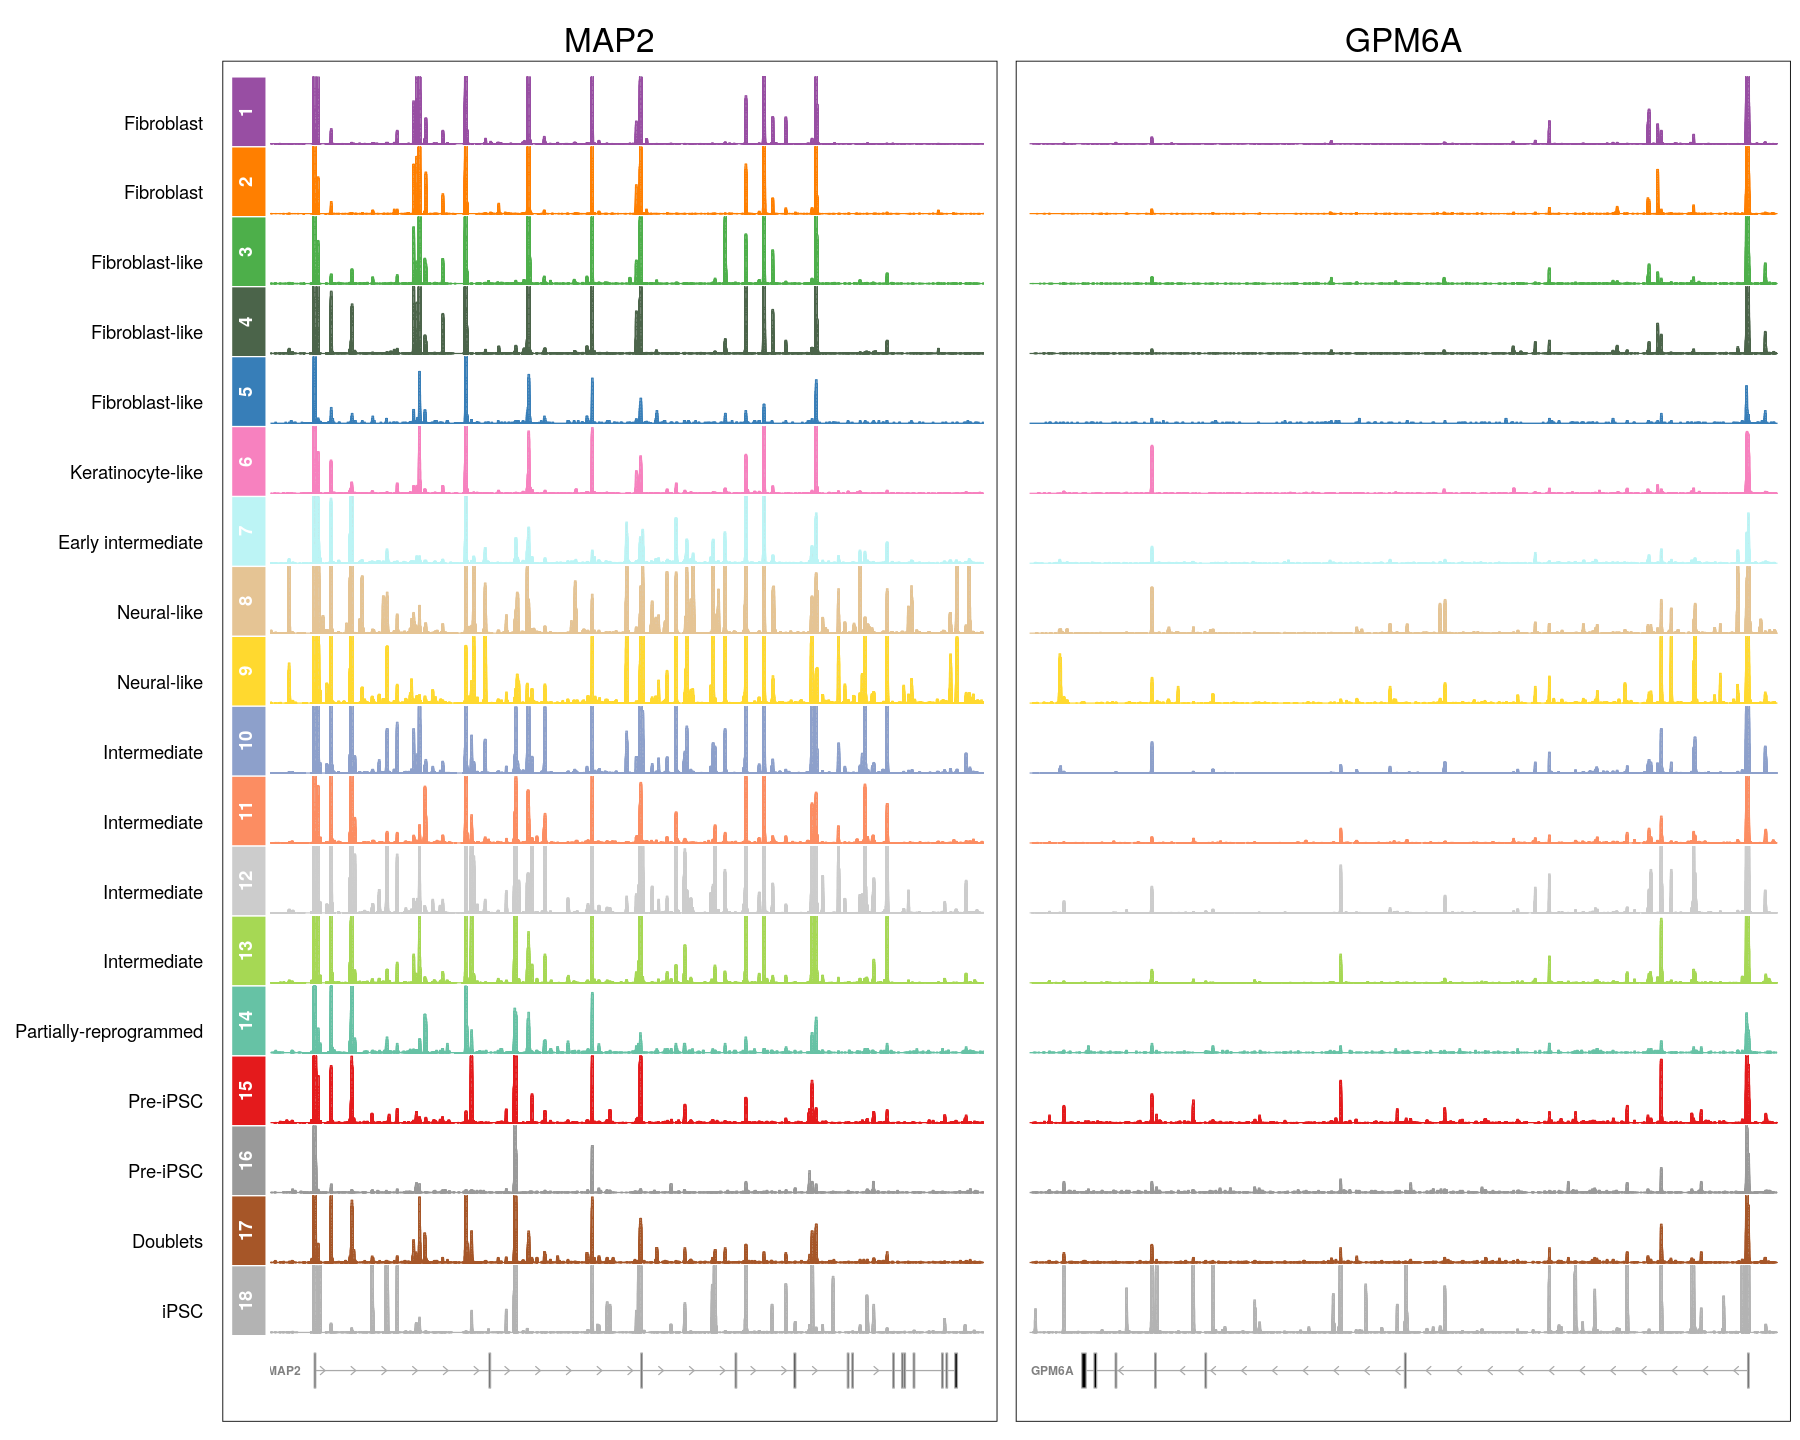

In [96]:
options(repr.plot.width = 15, repr.plot.height = 12)

myplot

In [102]:
myplot = wrap_plots(cluster_labels_plot,
                    KRT16,
                    plot_spacer(),
                    KLK11,
                    widths=c(3,6,0,6))

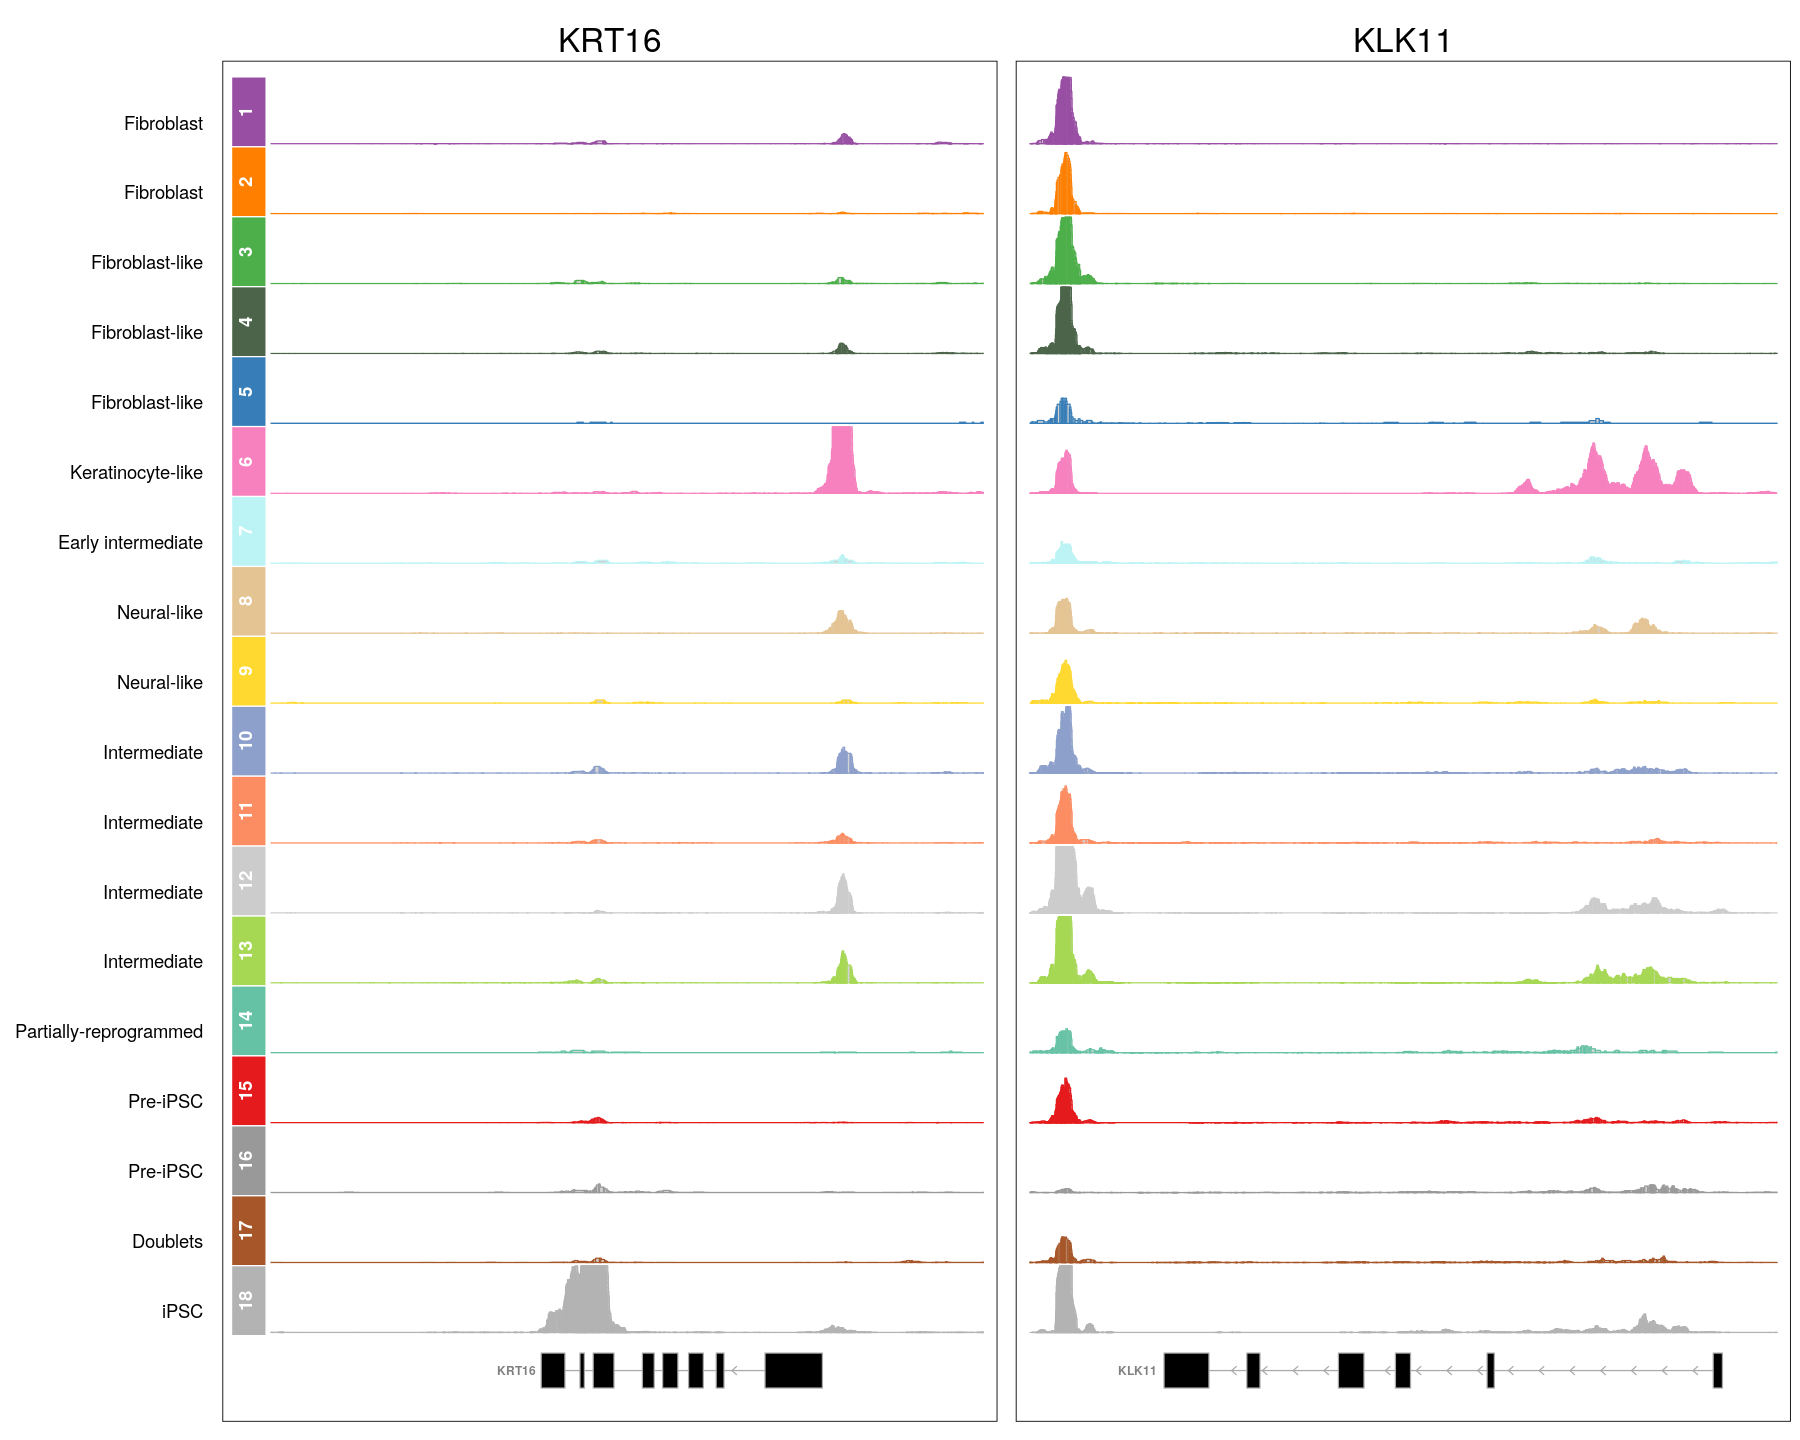

In [103]:
options(repr.plot.width = 15, repr.plot.height = 12)

myplot

In [111]:
ggsave("tmp.png", myplot, height=12, width=15)